# Final Resource

by Akaash Shah, Madison Smith, Seung Lee

## Introduction

Our goal of this research is to find out if picks and bans in a competitive match of DotA 2 can be used to predict the result.

##### What is DotA 2?

DotA 2 is a video game made by the company Valve and is in the genre of MOBA, Multiplayer Online Battle Arena, or ARTS, Action Real-Time Strategy. In each game, there are 10 players that are divided into two teams, Radiant and Dire. These 10 players each pick a character, or hero, from a pool of 117 heroes and fight to destroy the enemy stronghold, called Ancient. 

In a competitive game of DotA 2, Captain’s Mode is used to determine what heroes each player gets to pick. Each team, consisting of 5 players, bans 6 heros and picks 5 heroes in certain order. The metagame that forms around picking and banning results in a phenomena called “draft win” in certain matches where a team has a very high chance of winning, assuming no major difference in skills between the two teams, solely on the fact that they picked the right combination of characters versus their opponent. We feel that drafting in DotA 2 provides a unique opportunity to perform data analysis.

#### Why DotA 2?

Esports, or electronic sports, is a fast growing business that has reached [billion dollar revenue mark](https://newzoo.com/insights/articles/newzoo-global-esports-economy-will-top-1-billion-for-the-first-time-in-2019/). With some esports players earning [millions of dollars from tournaments](https://www.esportsearnings.com/) and sponsorships reaching $460 million, the stakes for each game are very high. If our research can find a model that can predict if a team can win based on picks alone, it has a chance to be adopted and used by the developers to help balance the game, which benefits esports enthusiasts in the end.



In [128]:
# Import packages
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from data_functions import *
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import warnings; warnings.simplefilter('ignore')

Data is from [this website](https://www.kaggle.com/pvkc8888/dota-2-pro-circuit-1718)

In [3]:
dpc = pd.read_json("data/DPC.json").transpose()

Here we are removing all the columns from the dataset we don't need and the first row as it contains all null values.

In [4]:
dpc.drop(["all_word_counts", "barracks_status_dire", "barracks_status_radiant", "chat", "cluster", "comeback", 
          "cosmetics", "dire_score", "series_type", "skill", "stomp", "teamfights", "throw", "tower_status_dire", 
          "tower_status_radiant", "loss", "leagueid", "duration", "engine", "first_blood_time", "radiant_xp_adv", 
          "replay_url", "radiant_gold_adv", "positive_votes", "radiant_score", "negative_votes", 
          "objectives", "dire_team_id", "radiant_team_id", "human_players", "league", "lobby_type", 
          "draft_timings", "my_word_counts", "region", "replay_salt", "series_id"], axis=1, inplace=True)
dpc.drop([1], inplace=True)

## The Data

In DotA 2, the metagame constantly changes due to the game balance brought by patches. Patches adjusts heroes by either nerfing, which is making them weaker, or buffing, which is making them stronger, them depending on how they performed in the previous patch. If the hero was picked often because it was considered strong, it is more likely that the hero would be nerfed in the next patch and vice versa. The most current balance patch is 7.21c put out on March 2, 2019. However, we are looking at 2017 to 2018 DotA Pro Circuit matches in our data. 

The 2017 - 2018 DotA 2 Pro Circuit contains 11 patches. The patches included are 7.06, 7.07, 7.08, 7.09, 7.10, 7.11, 7.12, 7.13, 7.14, 7.15, and 7.16. Among these, 7.06 was a remnant from the previous year’s Pro Circuit and was preceded by a major patch 7.07. Below is a table showing how many matches were played in each patch.

| Patch Number | Matches Played |
|--------------|----------------|
| 7.06         | 91             |
| 7.07         | 301            |
| 7.08         | 33             |
| 7.09         | 64             |
| 7.10         | 51             |
| 7.11         | 63             |
| 7.12         | 107            |
| 7.13         | 35             |
| 7.14         | 110            |
| 7.15         | 156            |
| 7.16         | 109            |

The most played patch is 7.07 with 301 matches and lowest is 7.08 with 33 matches. However, these numbers are too low to have effective results so we decided to merge these patches into major patch period on top of trying to run analysis on all of the data at once. The major patches we’re looking at are:

| Major Patches      | Matches Played |
|--------------------|----------------|
| patch 7.07 to 7.09 | 398            |
| patch 7.10 to 7.13 | 256            |
| patch 7.14 to 7.16 | 375            |

We determined the major patches through [this website](https://dota2.gamepedia.com/Game_Versions) where yellow highlighted patches are considered major patches. We removed 7.06 from our dataset because it’s relatively small at 91 and is not related to any other major patch.

Here we generate datasets based on certain features.

In [129]:
# has radiant picks/bans, dire picks/bans, team_ids, radiant win
patch707_combined = create_pick_ban_both_teams(dpc, 26, 28)
patch710_combined = create_pick_ban_both_teams(dpc, 29, 32)
patch714_combined = create_pick_ban_both_teams(dpc, 33, 36)
patchAll_combined = create_pick_ban_both_teams(dpc, 26, 36)

In [130]:
# has data for pick, ban, and win
patch707_single = create_pick_ban_1_team(dpc, 26, 28)
patch710_single = create_pick_ban_1_team(dpc, 29, 32)
patch714_single = create_pick_ban_1_team(dpc, 33, 36)
patchAll_single = create_pick_ban_1_team(dpc, 26, 36)

In [131]:
# has data for pick, ban, win, team_id
patch707_pbt = create_pick_ban_team(dpc, 26, 28)
patch710_pbt = create_pick_ban_team(dpc, 29, 32)
patch714_pbt = create_pick_ban_team(dpc, 33, 36)
patchAll_pbt = create_pick_ban_team(dpc, 26, 36)

In [132]:
# these are data with picks, team_id, and win
patch707_picks_team = create_picks_team(dpc, 26, 28)
patch710_picks_team = create_picks_team(dpc, 29, 32)
patch714_picks_team = create_picks_team(dpc, 33, 36)
patchAll_picks_team = create_picks_team(dpc, 26, 36)

In [133]:
# these are data with only picks and win (true,false)
patch707_picks = create_picks(dpc, 26, 28)
patch710_picks = create_picks(dpc, 29, 32)
patch714_picks = create_picks(dpc, 33, 36)
patchAll_picks = create_picks(dpc, 26, 36)

All the functions used to create the dataset are stored in data_functions.py

## Feature exploration
##### Looking for any features that might skew results or help better fit our models

Now that we have defined what are major patches are and split our data correctly we need to explore some other variables. Since this dataset is a set of matches from professional DotA we will be conducting this analysis under this assumption that there are no explicitly "bad" bans and every decision made is an educated one. Becasue of the professional nature of this dataset we expect there to be alot of parody, meaning no one pick or ban decides the outcome of the match. We are going to explore mainly weather looking at single teams data is more effective at predicting wins vs looking at both teams data during the character selection process. The last big thing to look at is if the individual teams should be included in the model. Do some teams dominate or is there so much parody that it actually negatively effects the predictions.We will first look at the overall dataset across patches, and then start exploring within major patches.


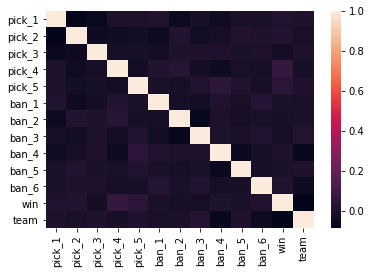

In [134]:
#first heat map of correlations of everything (all data), picks, bans, win, team. 
sns.heatmap(patchAll_pbt.astype(int).corr())

From this heat map of single teams picks and bans it seems that no variable seems to have a huge influence on winning. This would seem to indicate a lot of parody in the DotA professional circuit. 

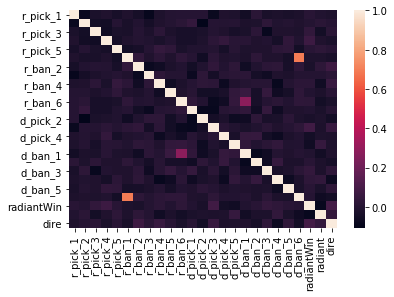

In [135]:
#Both teams per match picks and bans
sns.heatmap(patchAll_combined.astype(int).corr())

From this heat map now considering both teams picks and bans, we don't see anything concrete but notice that alot of bans are correlated too each other. We also notice a contrast in Radiant and Dire correlation to winning. The Dire team seems to be slightly more correlated to a radiant win than the radiant team itself. 
We also know looking at the DotA Rankings (https://liquipedia.net/dota2/Dota_Pro_Circuit/2017-18/Rankings) that there was in fact dominant and underperforming teams. So it is a little interesting to not see it come up on the heat maps.

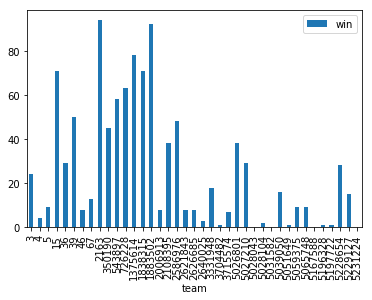

In [136]:
teams = patchAll_pbt[['win', 'team']]
team_win_df = pd.DataFrame(teams.groupby(['team']).sum())
team_win_df.plot.bar()

As we can see from the graph above and the table below, there are many teams that barely recorded any wins and only a handful of teams that won frequently. This indicates that who the team is matters and should be included in our final model despite it not seeming relevant in the heat graphs. 

In [137]:
team_win_df

,win
team,
3,24
4,4
5,9
15,71
36,29
39,50
46,8
67,13
2163,94


We see on a big scale that our heatmaps did not tell us much, but what happens when we break it down by patch? 

#### Patch 707

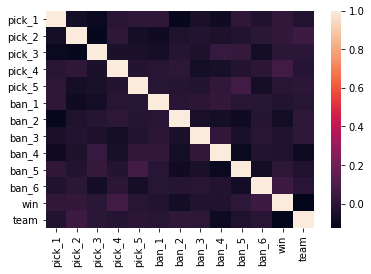

In [138]:
#Correlation heat charts. 
#For each patch, all data of picks, bans, win, team for single and combined. 

sns.heatmap(patch707_pbt.astype(int).corr())

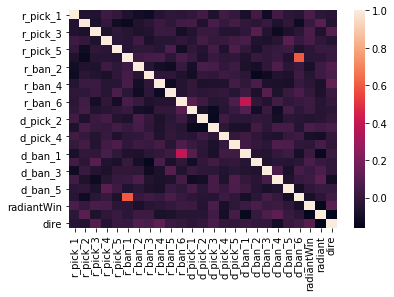

In [139]:
sns.heatmap(patch707_combined.astype(int).corr())

The trend in correlation all seem to reflect the overall data set trends. 

#### Patch 710

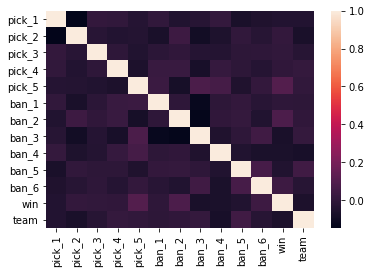

In [140]:
#single team bans, picks, win, team
sns.heatmap(patch710_pbt.astype(int).corr())

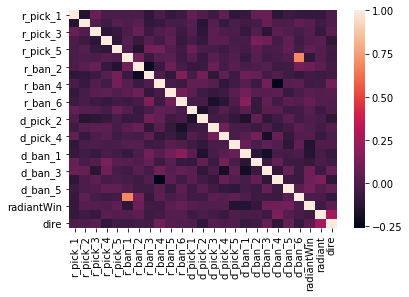

In [141]:
#combined teams (both teams in match) bans picks wins team
sns.heatmap(patch710_combined.astype(int).corr())

The heat map for Patch 710 when using both teams data is noticably brighter, indicating more positive correlation across the variables. Most importantly the radiant win seems to be effected by which team plays dire. 

#### Patch 714

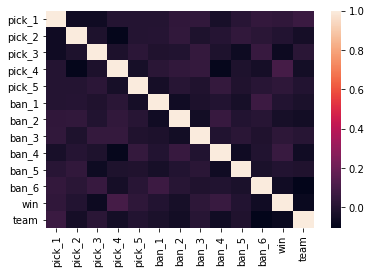

In [142]:
#single team bans, picks, win, team
sns.heatmap(patch714_pbt.astype(int).corr())

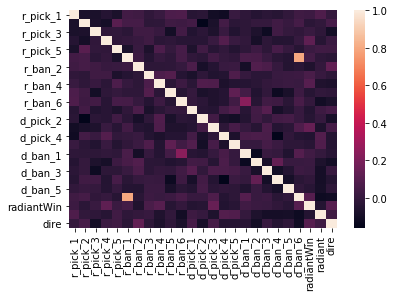

In [143]:
#combined teams (both teams in match) bans picks wins team
sns.heatmap(patch714_combined.astype(int).corr())

These heatmaps are unfortunately just as dark as the overall heat maps and cannot really help us mold this model. One thing we can note across the board is that using both teams combined data seems to have more positive correlation across the board. This makes sense as player's often pick based off what other teams' picks/ bans are. 

## Data Analysis

### Decision Tree 

This is a function that splits the data into testing and training data, creates a decision tree classifer, trains the model including scaling variables, cross validatation and feeding our training data, and assessing the accuracy of the model using the testing data. It returns the accuracy that the model found for this particular model and dataset.

In [144]:
def decision_tree_function(data):
    
    # looking for categories and we have numbers-- switch ints to strings
    for i in list(data):
        if i != 'win' and i != 'team' and i != 'radiant' and i != 'dire':
            data[i] = data[i].astype(int)

    # split data
    train_features, test_features, train_outcome, test_outcome = train_test_split(
       data.drop("radiantWin", axis=1),     
       data.loc[: , "radiantWin"],    
       test_size=0.50
    )

    # solves an error about unknown labels
    train_outcome = np.asarray(train_outcome, dtype="|S6")
    test_outcome = np.asarray(test_outcome, dtype="|S6")
    
    # create classifer
    tree_clf = DecisionTreeClassifier()

    # grid search with preprocessing
    pipeline = make_pipeline(MinMaxScaler(), tree_clf)
    param_grid = {'decisiontreeclassifier__max_depth': np.arange(3, 20), 'decisiontreeclassifier__criterion': ["gini", "entropy"], 'decisiontreeclassifier__splitter': ["best", "random"], 'decisiontreeclassifier__min_samples_split': np.arange(2, 20)} 

    # pass pipeline to grid search
    grid = GridSearchCV(pipeline, param_grid, cv=3)

    grid.fit(train_features, train_outcome)
    return grid.score(test_features, test_outcome)
    

### Linear SCV

https://scikit-learn.org/stable/modules/svm.html#classification

Similar to the Decision Tree function, this is a function that splits the data into testing and training data, creates a linear SVC classifer model, trains the model including scaling, cross validation and feeding our training data, and assesses the accuracy of the model using the testing data. It returns the accuracy that the model found for this particular model and dataset.

In [145]:
def linear_scv_function(data):    
    
    # looking for categories and we have numbers-- switch ints to strings
    for i in list(data):
        if i != 'win' and i != 'team' and i != 'radiant' and i != 'dire':
            data[i] = data[i].astype(int)

    # split data
    train_features, test_features, train_outcome, test_outcome = train_test_split(
       data.drop("radiantWin", axis=1),     
       data.loc[: , "radiantWin"],    
       test_size=0.50
    )

    # solves an error about unknown labels
    train_outcome = np.asarray(train_outcome, dtype="|S6")
    test_outcome = np.asarray(test_outcome, dtype="|S6")
    
    # create classifer
    clf_svm = svm.SVC(gamma='scale')

    # grid search with preprocessing
    pipeline = make_pipeline(MinMaxScaler(), clf_svm)
    parameter_grid = {} 

    # pass pipeline to grid search
    grid = GridSearchCV(pipeline, parameter_grid)
    grid.fit(train_features, train_outcome)
    return grid.score(test_features, test_outcome)


### Train Models and Get Results

Next we call both of those functions for each patch dataset- patch707_combined, patch710_combined, patch714_combined, and patchAll_combined. This means that for each data set, a decision tree classifer model and a linear SVC model will be trained and tested to determine the accuracy of the model. The results are below.

In [146]:
# run all the models on all the data, get array in return

sub_datasets = [patch707_combined, patch710_combined, patch714_combined, patchAll_combined]
decision_tree_results = []
linear_svc_results = []
for i in sub_datasets: 
    decision_tree_results.append(decision_tree_function(i))
    linear_svc_results.append(linear_scv_function(i))
    

In [147]:
print("Decision Tree Results: ")
print("patch707_combined: " + str(decision_tree_results[0]))
print("patch710_combined: " + str(decision_tree_results[1]))
print("patch714_combined: " + str(decision_tree_results[2]))
print("patchAll_combined: " + str(decision_tree_results[3]))
print(" ")
print("Linear SVC Results: ")
print("patch707_combined: " + str(linear_svc_results[0]))
print("patch710_combined: " + str(linear_svc_results[1]))
print("patch714_combined: " + str(linear_svc_results[2]))
print("patchAll_combined: " + str(linear_svc_results[3]))

Decision Tree Results: 
patch707_combined: 0.4972972972972973
patch710_combined: 0.5118110236220472
patch714_combined: 0.48663101604278075
patchAll_combined: 0.531062124248497
 
Linear SVC Results: 
patch707_combined: 0.5027027027027027
patch710_combined: 0.5354330708661418
patch714_combined: 0.6042780748663101
patchAll_combined: 0.533066132264529


The decision tree accuracy hovers right around 50%, which given that there are only two categories, win or lose, is not more accurate than a coinflip. So, predicting whether a team wins or loses, even accounting for different patches, is very difficult. This makes sense because if predicting the outcome of games were easy, then the games would not be interesting. 

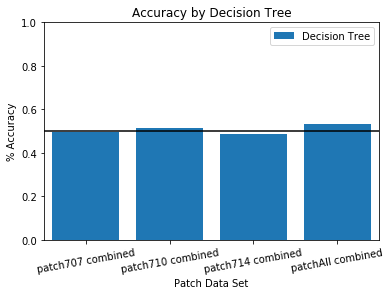

In [148]:
plt.bar(["patch707 combined", "patch710 combined", "patch714 combined", "patchAll combined"], decision_tree_results, label="Decision Tree")
plt.plot([-0.5, 3.5], [0.5, 0.5], color="black")
plt.xlabel("Patch Data Set")
plt.ylabel("% Accuracy")
plt.xticks(rotation=10)
plt.legend()
plt.title("Accuracy by Decision Tree")
plt.axis([-0.5, 3.5, 0, 1])

plt.show()

The Linear SVC model's accuracy, while also hovering close to 50%, is slightly higher than the Decision Tree's accuracy. This may be due to the randomness of our samples, rather than a better performing model. However, overall, this model doesn't fair much better than the Decision Tree mode, further demonstrating that predicting the outcome of these games is difficult.

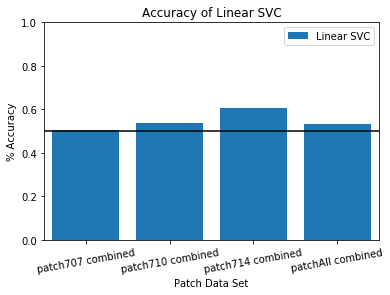

In [149]:
plt.bar(["patch707 combined", "patch710 combined", "patch714 combined", "patchAll combined"], linear_svc_results, label="Linear SVC")
plt.plot([-0.5, 3.5], [0.5, 0.5], color="black")
plt.xlabel("Patch Data Set")
plt.ylabel("% Accuracy")
plt.xticks(rotation=10)
plt.legend()
plt.title("Accuracy of Linear SVC")
plt.axis([-0.5, 3.5, 0, 1])

plt.show()

In this case the patch 714 is slightly easier to predict, with a value at 60%. However, this isn't sigificant enough to say that the difference is due to the patch rather than random chance. Separating out patches into separate datasets or combining patches does not seem to make a sigificant differenc either because all the datasets seems to hover around the same values. 

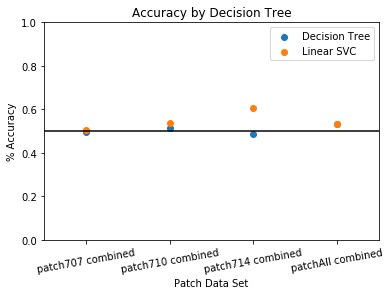

In [150]:
plt.scatter(["patch707 combined", "patch710 combined", "patch714 combined", "patchAll combined"], decision_tree_results, label="Decision Tree")
plt.scatter(["patch707 combined", "patch710 combined", "patch714 combined", "patchAll combined"], linear_svc_results, label="Linear SVC")
plt.plot([-0.5, 3.5], [0.5, 0.5], color="black")
plt.xlabel("Patch Data Set")
plt.ylabel("% Accuracy")
plt.xticks(rotation=10)
plt.legend()
plt.title("Accuracy by Decision Tree")
plt.axis([-0.5, 3.5, 0, 1])

plt.show()

### Bonus: Multi-layer Perceptron

Multi-layer Perceptron (MLP) is a supervised learning algorithm. It's a simple neural network that processes features through layers with certain number of nodes.

First we create the training and test dataframes of first major patch.

In [125]:
hero_df, win_df = create_vector(dpc, 26, 27)
hero_test_df, win_test_df = create_vector(dpc, 28, 28)

Here, we're calculating for optimal number of nodes and layers.

In [126]:
results = []
comb = []

layers = np.arange(0, 10)
layers = layers[10:0:-1]
for n in np.arange(1, 50):
    for l in layers:
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(n, l), random_state=1)
        clf.fit(hero_df, win_df.values.ravel())

        results.append(accuracy_score(clf.predict(hero_test_df), win_test_df))
        comb.append("nodes: " + str(n) + " " + "layers: " + str(l))

In [127]:
counter = 0
maxP = 0
maxPL = 0
for x in results:
    if maxP < x:
        maxP = x
        maxPL = counter
    counter += 1
print("Accuracy Score: " + str(maxP))
print(comb[maxPL])

Accuracy Score: 0.625
nodes: 8 layers: 1


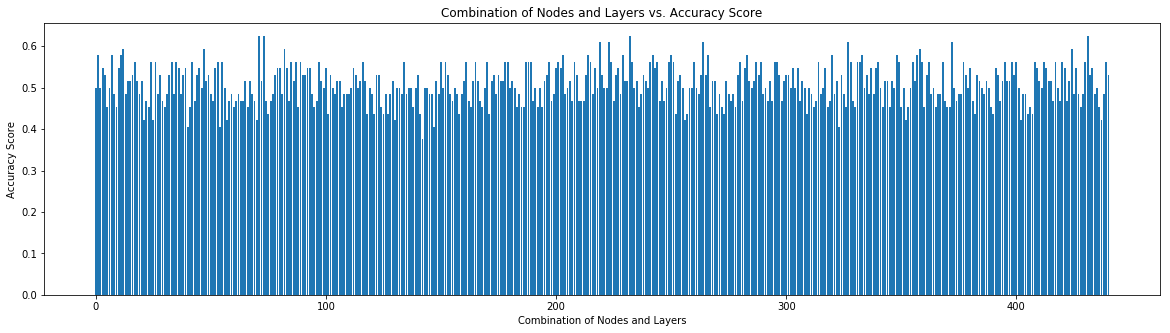

In [118]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(0, 441), results)
plt.xlabel("Combination of Nodes and Layers")
plt.ylabel("Accuracy Score")
plt.title("Combination of Nodes and Layers vs. Accuracy Score")
plt.show()

Here, we're testing for optimal number of iterations with above results.

In [120]:
result_iter = []
counter = 1
maxP = 0
maxPL = 0

for x in np.arange(1, 100):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 1), random_state=1, max_iter=x)
    clf.fit(hero_df, win_df.values.ravel())
    score = accuracy_score(clf.predict(hero_test_df), win_test_df)
    result_iter.append(score)
    if maxP < score:
        maxP = score
        maxPL = counter
    counter += 1

Highest Accuracy: 0.625
Number of iterations: 49


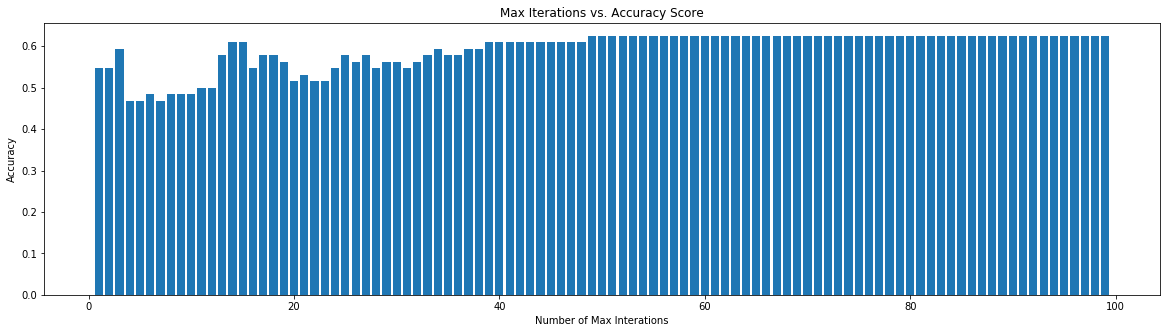

In [121]:
print("Highest Accuracy: " + str(maxP))
print("Number of iterations: " + str(maxPL))
plt.figure(figsize=(20, 5))
plt.bar(np.arange(1, 100), result_iter)
plt.xlabel("Number of Max Interations")
plt.ylabel("Accuracy")
plt.title("Max Iterations vs. Accuracy Score")
plt.show()

We can see that accuracy peaks at 48 but is kept for the rest of iterations.

Now we try it on other major patches.

In [114]:
hero_df, win_df = create_vector(dpc, 26, 27)
hero_test_df, win_test_df = create_vector(dpc, 28, 28)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 1), random_state=1, max_iter=49)
clf.fit(hero_df, win_df.values.ravel())
print("patch 7.07 to 7.12: " + str(accuracy_score(clf.predict(hero_test_df), win_test_df)))

hero_df, win_df = create_vector(dpc, 29, 31)
hero_test_df, win_test_df = create_vector(dpc, 32, 32)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 1), random_state=1, max_iter=49)
clf.fit(hero_df, win_df.values.ravel())
print("patch 7.10 to 7.13: " + str(accuracy_score(clf.predict(hero_test_df), win_test_df)))

hero_df, win_df = create_vector(dpc, 33, 34)
hero_test_df, win_test_df = create_vector(dpc, 35, 36)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 1), random_state=1, max_iter=49)
clf.fit(hero_df, win_df.values.ravel())
print("patch 7.14 to 7.16: " + str(accuracy_score(clf.predict(hero_test_df), win_test_df)))

hero_df, win_df = create_vector(dpc, 26, 34)
hero_test_df, win_test_df = create_vector(dpc, 35, 36)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 1), random_state=1, max_iter=49)
clf.fit(hero_df, win_df.values.ravel())
print("patch 7.07 to 7.16: " + str(accuracy_score(clf.predict(hero_test_df), win_test_df)))

patch 7.07 to 7.12: 0.625
patch 7.10 to 7.13: 0.5294117647058824
patch 7.14 to 7.16: 0.3761467889908257
patch 7.07 to 7.16: 0.3944954128440367


## Conclusion

Overall, our Decision tree model performed decently for patch 714 and our SVC model performed decently for all the data combined. With only a total of 997 games our dataset was certainly not as large as we would have liked. Even with our limited dataset we were able to predict results 60% of the time depending on patch and model. 

With the multi-layer perceptron, or MLP, performed well when given patch data sequentially. For example, if we trained on patch 7.07 and 7.08 then it would do okay in predicting what would happen in 7.09, about 0.62 accuracy score. However, when we tested on rest of the patches, it performed 0.52, 0.37 for two other major patches, and 0.39 for testing it on all the data. This is probably the result of picking nodes, layers, and iterations based on the first major patch data.

In the end, the difficulty we found in predicting the outcomes of DotA games illustrates the complexity of the game. There are many factors that contribute to the win or loss of the game beyond the players on each of the team and this was not something that we included in our analysis due to limited scope and time. But the complexity is a part of what makes the game interesting. If the outcomes of games could be predicted only off the players on each team, then the games would hold little interest. 